#Linear Regression: Predicting California Housing Prices

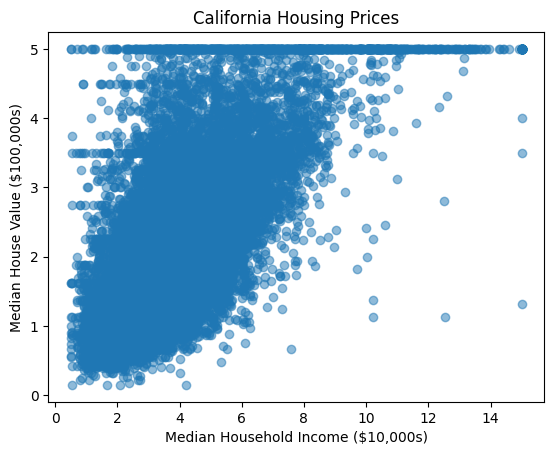


--- Batch Gradient Descent ---
Mean Squared Error (MSE): 0.7091
Root Mean Squared Error (RMSE): 0.8421
R² Score: 0.4589
Mean Absolute Error (MAE): 0.6299
Mean Absolute Percentage Error (MAPE): 39.06%

--- Stochastic Gradient Descent ---
Mean Squared Error (MSE): 0.7096
Root Mean Squared Error (RMSE): 0.8424
R² Score: 0.4585
Mean Absolute Error (MAE): 0.6264
Mean Absolute Percentage Error (MAPE): 38.46%


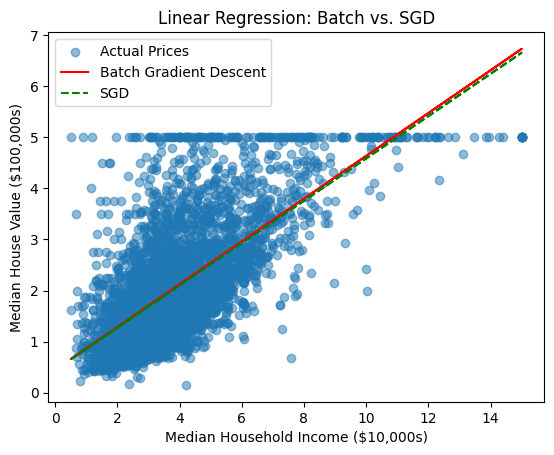


Predicted House Price for MedInc = $80,000:
Batch Gradient Descent: $379930.52
Stochastic Gradient Descent: $375820.37


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Load the California Housing Dataset ---
data = fetch_california_housing()
X = data.data  # Features
y = data.target  # Median house value (in $100,000s)

# Convert to DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df["Target"] = y

# Focus on a single feature (MedInc) for simple linear regression
X = df[["MedInc"]].values
y = df["Target"].values

# --- 2. Visualize Data ---
plt.scatter(X, y, alpha=0.5)
plt.xlabel("Median Household Income ($10,000s)")
plt.ylabel("Median House Value ($100,000s)")
plt.title("California Housing Prices")
plt.show()

# --- 3. Split into Train & Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Train Linear Regression Model (Batch Gradient Descent) ---
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# --- 5. Train Stochastic Gradient Descent (SGD) Model ---
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate="invscaling", eta0=0.01, random_state=42)
sgd_regressor.fit(X_train, y_train)

# --- 6. Predictions ---
y_pred_batch = regressor.predict(X_test)
y_pred_sgd = sgd_regressor.predict(X_test)

# --- 7. Evaluate Model Performance ---
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Convert to percentage

    print(f"\n--- {model_name} ---")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Evaluate Batch Gradient Descent
evaluate_model("Batch Gradient Descent", y_test, y_pred_batch)

# Evaluate Stochastic Gradient Descent
evaluate_model("Stochastic Gradient Descent", y_test, y_pred_sgd)

# --- 8. Plot Regression Line ---
plt.scatter(X_test, y_test, alpha=0.5, label="Actual Prices")
plt.plot(X_test, y_pred_batch, color="red", label="Batch Gradient Descent")
plt.plot(X_test, y_pred_sgd, color="green", linestyle="dashed", label="SGD")
plt.xlabel("Median Household Income ($10,000s)")
plt.ylabel("Median House Value ($100,000s)")
plt.legend()
plt.title("Linear Regression: Batch vs. SGD")
plt.show()

# --- 9. Predict House Price for MedInc = $80,000 (8.0) ---
new_income = np.array([[8.0]])
predicted_price_batch = regressor.predict(new_income)[0]
predicted_price_sgd = sgd_regressor.predict(new_income)[0]

print(f"\nPredicted House Price for MedInc = $80,000:")
print(f"Batch Gradient Descent: ${predicted_price_batch * 100_000:.2f}")
print(f"Stochastic Gradient Descent: ${predicted_price_sgd * 100_000:.2f}")


#Human Activity Recognition using Support Vector Machines

In [ ]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. DATA LOADING AND PREPROCESSING ---
# Define dataset paths
PATH = "/content/drive/MyDrive/datasets/UCI HAR Dataset"

# Load and clean feature names
features = pd.read_csv(PATH + "/features.txt", sep="\s+", header=None, names=["idx", "feature"])

# Handle duplicate features by appending _1, _2 etc.
features['feature'] = features.groupby('feature')['feature'].transform(
    lambda x: x + '_' + x.groupby(x).cumcount().astype(str).str.replace('_0$', '', regex=True))
feature_names = features['feature'].tolist()

# Load activity labels
activity_labels = pd.read_csv(PATH + "/activity_labels.txt", sep="\s+", header=None, names=["id", "activity"])
activity_map = dict(zip(activity_labels['id'], activity_labels['activity']))

# Load datasets
X_train = pd.read_csv(PATH + "/train/X_train.txt", sep="\s+", header=None, names=feature_names)
y_train = pd.read_csv(PATH + "/train/y_train.txt", sep="\s+", header=None, names=["label"])
X_test = pd.read_csv(PATH + "/test/X_test.txt", sep="\s+", header=None, names=feature_names)
y_test = pd.read_csv(PATH + "/test/y_test.txt", sep="\s+", header=None, names=["label"])

# --- 2. BINARY LABEL CONVERSION ---
def to_binary(activity_id):
    activity_name = activity_map[activity_id]
    if activity_name in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]:
        return 1  # Active
    return 0  # Inactive

y_train['binary'] = y_train['label'].apply(to_binary)
y_test['binary'] = y_test['label'].apply(to_binary)

# Convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train['binary'].values
y_test = y_test['binary'].values

# --- 3. SVM PIPELINE WITH DIMENSIONALITY REDUCTION ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # Reduces to 50 principal components
    ('svm', SVC(class_weight='balanced', random_state=42))
])

# --- 4. HYPERPARAMETER TUNING ---
param_grid = [
    {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10]},
    {'svm__kernel': ['rbf'], 'svm__C': [0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1]},
    {'svm__kernel': ['poly'], 'svm__degree': [2, 3], 'svm__C': [1, 10], 'svm__gamma': [0.01, 0.1]}
]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# --- 5. EVALUATION ---
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy: {:.2f}%".format(grid_search.best_score_*100))

# Test set evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'svm__C': 1, 'svm__degree': 3, 'svm__gamma': 0.01, 'svm__kernel': 'poly'}
Best CV Accuracy: 99.93%

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947

Confusion Matrix:
[[1559    1]
 [   0 1387]]
